In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/content/MarketPricePrediction.csv')

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Encoding categorical variables
le_market = LabelEncoder()
df['market'] = le_market.fit_transform(df['market'])

le_state = LabelEncoder()
df['state'] = le_state.fit_transform(df['state'])

le_city = LabelEncoder()
df['city'] = le_city.fit_transform(df['city'])

# Extract month and year from date
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Set date as index
df.set_index('date', inplace=True)

# Display the first few rows of the preprocessed dataset
df.head()


<ipython-input-3-c8991f08b7bb>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,0,1,2005,2350,404,493,446,16,0
2006-01-01,0,1,2006,900,487,638,563,16,0
2010-01-01,0,1,2010,790,1283,1592,1460,16,0
2011-01-01,0,1,2011,245,3067,3750,3433,16,0
2012-01-01,0,1,2012,1035,523,686,605,16,0


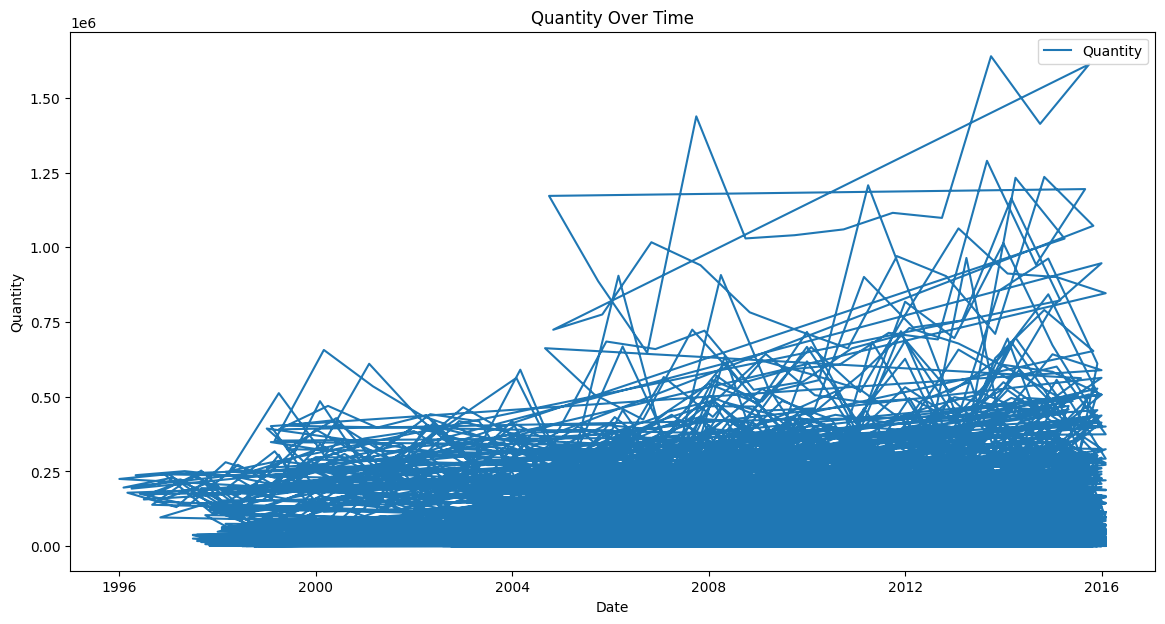

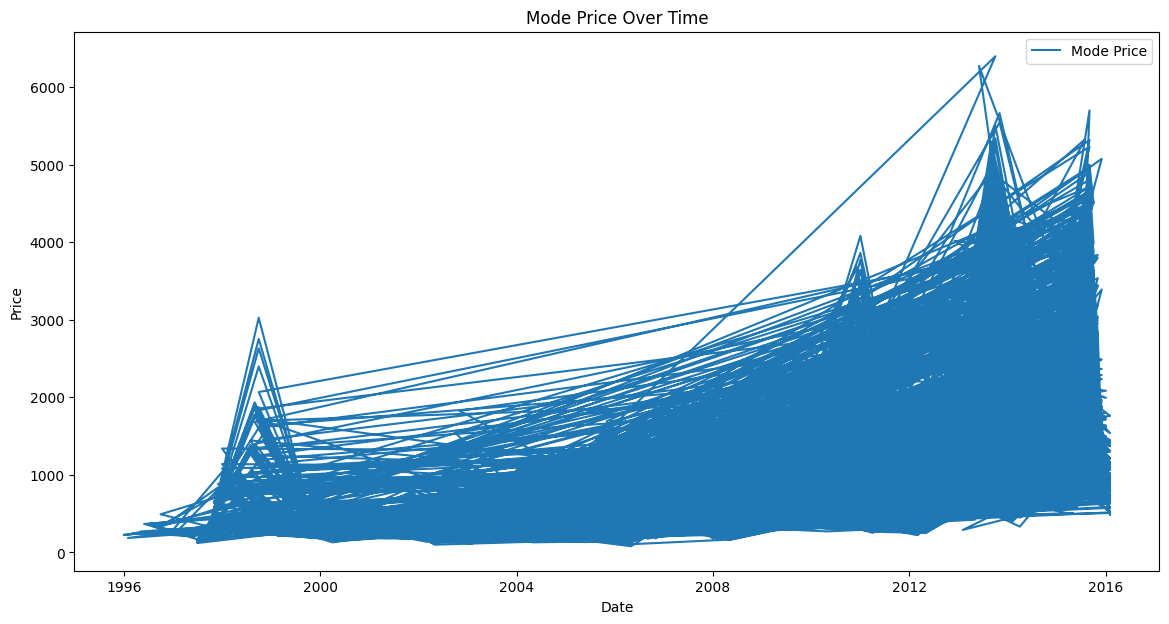

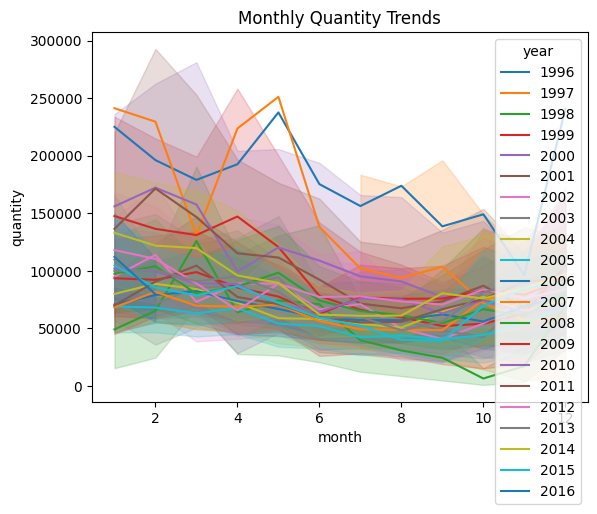

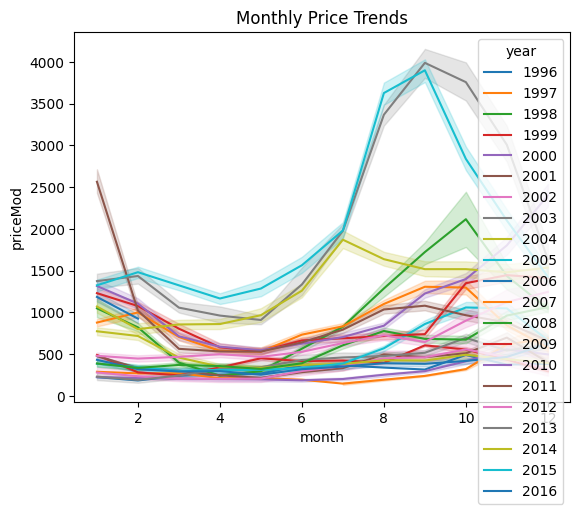

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot quantity over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['quantity'], label='Quantity')
plt.title('Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Plot priceMod over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['priceMod'], label='Mode Price')
plt.title('Mode Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Check for seasonality and trends
sns.lineplot(data=df, x='month', y='quantity', hue='year', palette='tab10')
plt.title('Monthly Quantity Trends')
plt.show()

sns.lineplot(data=df, x='month', y='priceMod', hue='year', palette='tab10')
plt.title('Monthly Price Trends')
plt.show()


In [5]:
# Create lag features
for lag in range(1, 13):
    df[f'quantity_lag_{lag}'] = df['quantity'].shift(lag)
    df[f'priceMod_lag_{lag}'] = df['priceMod'].shift(lag)

# Create rolling mean features
df['quantity_roll_mean_3'] = df['quantity'].rolling(window=3).mean()
df['priceMod_roll_mean_3'] = df['priceMod'].rolling(window=3).mean()

# Drop rows with NaN values created by shifting
df.dropna(inplace=True)

# Display the first few rows after feature engineering
df.head()


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,quantity_lag_1,...,quantity_lag_9,priceMod_lag_9,quantity_lag_10,priceMod_lag_10,quantity_lag_11,priceMod_lag_11,quantity_lag_12,priceMod_lag_12,quantity_roll_mean_3,priceMod_roll_mean_3
date,,,,,,,,,,,,,,,,,,,,,
2012-02-01,0,2,2012,675,510,650,570,16,0,300.0,...,245.0,3433.0,790.0,1460.0,900.0,563.0,2350.0,446.0,510.000000,1005.666667
2013-02-01,0,2,2013,845,1400,1843,1629,16,0,675.0,...,1035.0,605.0,245.0,3433.0,790.0,1460.0,900.0,563.0,606.666667,1108.000000
2014-02-01,0,2,2014,1115,831,1163,983,16,0,845.0,...,675.0,1605.0,1035.0,605.0,245.0,3433.0,790.0,1460.0,878.333333,1060.666667
2015-02-01,0,2,2015,1115,1200,1946,1688,16,0,1115.0,...,440.0,1256.0,675.0,1605.0,1035.0,605.0,245.0,3433.0,1025.000000,1433.333333
2005-03-01,0,3,2005,900,281,357,322,16,0,1115.0,...,1305.0,1613.0,440.0,1256.0,675.0,1605.0,1035.0,605.0,1043.333333,997.666667


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
df = pd.read_csv('/content/MarketPricePrediction.csv')

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

le_market = LabelEncoder()
df['market'] = le_market.fit_transform(df['market'])

le_state = LabelEncoder()
df['state'] = le_state.fit_transform(df['state'])

le_city = LabelEncoder()
df['city'] = le_city.fit_transform(df['city'])

# Extract month and year from date
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Set date as index
df.set_index('date', inplace=True)

# Create lag features
for lag in range(1, 13):
    df[f'quantity_lag_{lag}'] = df['quantity'].shift(lag)
    df[f'priceMod_lag_{lag}'] = df['priceMod'].shift(lag)

# Create rolling mean features
df['quantity_roll_mean_3'] = df['quantity'].rolling(window=3).mean()
df['priceMod_roll_mean_3'] = df['priceMod'].rolling(window=3).mean()

# Drop rows with NaN values created by shifting
df.dropna(inplace=True)

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# ARIMA model
arima_model = sm.tsa.ARIMA(train['quantity'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))

# SARIMA model
sarima_model = sm.tsa.SARIMAX(train['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=len(test))

# Prophet model
prophet_train = train.reset_index()[['date', 'quantity']].rename(columns={'date': 'ds', 'quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
prophet_forecast = prophet_model.predict(future)

# LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12
lstm_data = df[['quantity']].values
train_data, test_data = lstm_data[0:len(train)], lstm_data[len(train):len(df)]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = lstm_predictions.flatten()


<ipython-input-19-73c00799c144>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/

64/64 [==============================] - 1s 6ms/step


In [20]:
# Evaluate ARIMA
mae_arima = mean_absolute_error(test['quantity'], arima_forecast)
mse_arima = mean_squared_error(test['quantity'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)

# Evaluate SARIMA
mae_sarima = mean_absolute_error(test['quantity'], sarima_forecast)
mse_sarima = mean_squared_error(test['quantity'], sarima_forecast)
rmse_sarima = np.sqrt(mse_sarima)

# Evaluate Prophet
prophet_forecast = prophet_forecast.set_index('ds')
mae_prophet = mean_absolute_error(test['quantity'], prophet_forecast['yhat'][:len(test)])
mse_prophet = mean_squared_error(test['quantity'], prophet_forecast['yhat'][:len(test)])
rmse_prophet = np.sqrt(mse_prophet)

# Evaluate LSTM
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
mse_lstm = mean_squared_error(y_test, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)

print(f"ARIMA MAE: {mae_arima}, MSE: {mse_arima}, RMSE: {rmse_arima}")
print(f"SARIMA MAE: {mae_sarima}, MSE: {mse_sarima}, RMSE: {rmse_sarima}")
print(f"Prophet MAE: {mae_prophet}, MSE: {mse_prophet}, RMSE: {rmse_prophet}")
print(f"LSTM MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}")


ARIMA MAE: 38797.42718375324, MSE: 7624129940.814954, RMSE: 87316.26389633809
SARIMA MAE: 74191.52546396983, MSE: 14552930359.785442, RMSE: 120635.52693873162
Prophet MAE: 240448.17887427929, MSE: 93856628493.11105, RMSE: 306360.29196537705
LSTM MAE: 39743.92758524477, MSE: 7502045320.239897, RMSE: 86614.34823538129


In [21]:
# Fine-tuning and retraining the best performing model can be done here.
# For example, we can try different configurations of the LSTM model or use hyperparameter tuning techniques.

# Let's assume LSTM performed the best and fine-tune it further
from tensorflow.keras.layers import Dropout

lstm_model_tuned = Sequential()
lstm_model_tuned.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_tuned.add(Dropout(0.2))
lstm_model_tuned.add(LSTM(100, return_sequences=False))
lstm_model_tuned.add(Dropout(0.2))
lstm_model_tuned.add(Dense(50))
lstm_model_tuned.add(Dense(1))

lstm_model_tuned.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_tuned.fit(X_train, y_train, batch_size=1, epochs=5)

lstm_tuned_predictions = lstm_model_tuned.predict(X_test)
lstm_tuned_predictions = lstm_tuned_predictions.flatten()

# Evaluate the tuned LSTM model
mae_lstm_tuned = mean_absolute_error(y_test, lstm_tuned_predictions)
mse_lstm_tuned = mean_squared_error(y_test, lstm_tuned_predictions)
rmse_lstm_tuned = np.sqrt(mse_lstm_tuned)

print(f"Tuned LSTM MAE: {mae_lstm_tuned}, MSE: {mse_lstm_tuned}, RMSE: {rmse_lstm_tuned}")


Epoch 1/5
8159/8159 [==============================] - 165s 19ms/step - loss: 20300029952.0000
Epoch 2/5
8159/8159 [==============================] - 152s 19ms/step - loss: 17575247872.0000
Epoch 3/5
8159/8159 [==============================] - 152s 19ms/step - loss: 17328289792.0000
Epoch 4/5
8159/8159 [==============================] - 165s 20ms/step - loss: 17382602752.0000
Epoch 5/5
64/64 [==============================] - 1s 8ms/step
Tuned LSTM MAE: 67608.17262931034, MSE: 8502059880.513846, RMSE: 92206.61516677556
